In [ ]:
pip install scikit-learn

  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl (10.7 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   ---------------

In [ ]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install autots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.9/974.9 kB 11.0 MB/s eta 0:00:00


In [19]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Data/AEP_hourly.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])      # Ubah ke datetime
df.set_index('Datetime', inplace=True)               # Jadikan index

In [5]:
# Agregasi total harian
daily_df = df.resample('D').sum()

In [6]:
daily_df.head()

,AEP_MW
Datetime,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0


In [7]:
daily_df.tail()

,AEP_MW
Datetime,
2018-07-30,368834.0
2018-07-31,364327.0
2018-08-01,363628.0
2018-08-02,376504.0
2018-08-03,14809.0


In [8]:
print(daily_df.shape)

(5055, 1)


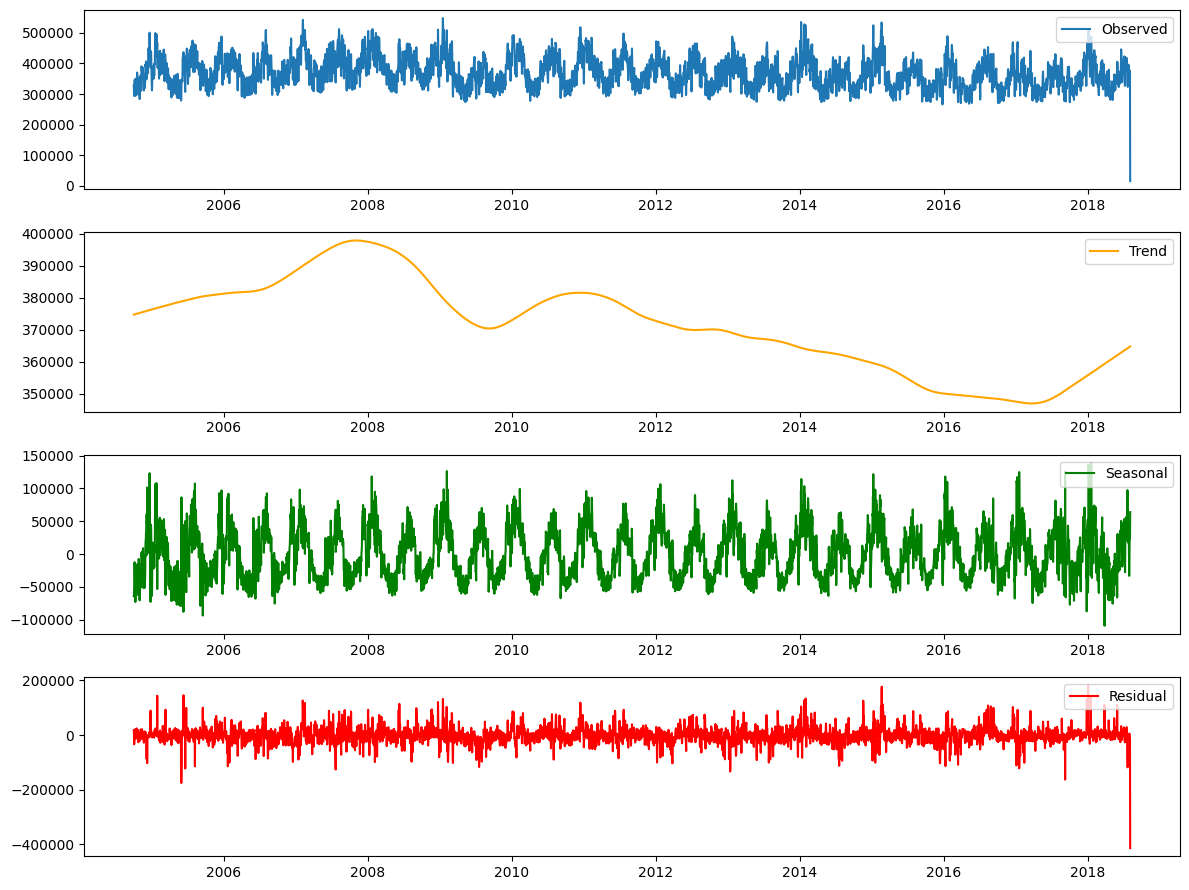

In [13]:
# Decomposisi time series
decomposition = seasonal_decompose(daily_df['AEP_MW'], model='additive', period=30)
stl = STL(daily_df['AEP_MW'], period=365, robust=True)
res = stl.fit()

plt.figure(figsize=(12, 9))

plt.subplot(411)
plt.plot(daily_df.index, daily_df['AEP_MW'], label='Observed')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(daily_df.index, res.trend, label='Trend', color='orange')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(daily_df.index, res.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(daily_df.index, res.resid, label='Residual', color='red')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [14]:
# Ambil data total konsumsi harian (tanpa NaN)
data = daily_df['AEP_MW']

# Lakukan ADF test
adf_result = adfuller(data)

# Cetak hasil ADF
print("=== Hasil ADF Test ===")
print(f"ADF Statistic     : {adf_result[0]}")
print(f"p-value           : {adf_result[1]}")
print("Critical Values   :")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretasi sederhana
if adf_result[1] < 0.05:
    print("\n✅ Data bersifat stasioner (p-value < 0.05)")
else:
    print("\n❌ Data tidak stasioner (p-value >= 0.05), perlu differencing")

print(f"Lag Used          : {adf_result[2]}")
print(f"Number of Observations Used: {adf_result[3]}")

=== Hasil ADF Test ===
ADF Statistic     : -7.2795963551457294
p-value           : 1.5125837189548453e-10
Critical Values   :
   1%: -3.4316522779278373
   5%: -2.8621154666284063
   10%: -2.5670763214801435

✅ Data bersifat stasioner (p-value < 0.05)
Lag Used          : 30
Number of Observations Used: 5024


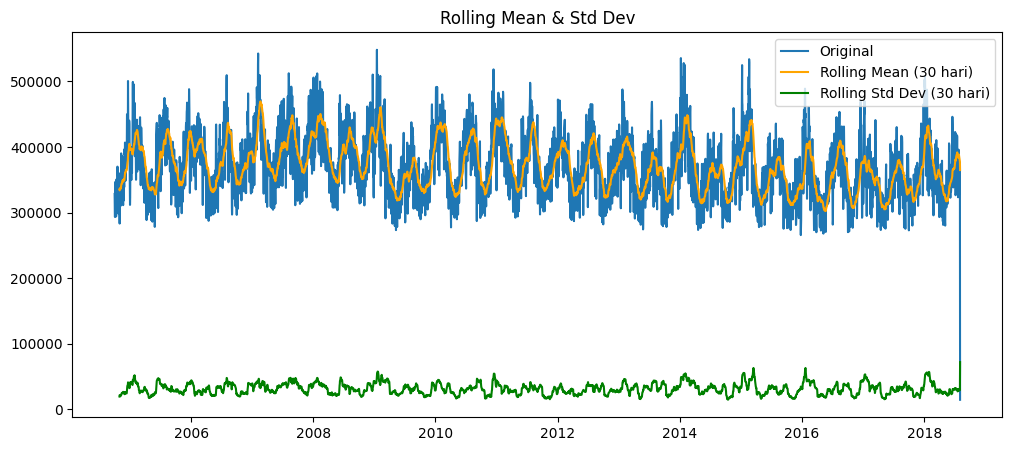

In [15]:
rolling_mean = daily_df['AEP_MW'].rolling(window=30).mean()
rolling_std = daily_df['AEP_MW'].rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(daily_df['AEP_MW'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (30 hari)', color='orange')
plt.plot(rolling_std, label='Rolling Std Dev (30 hari)', color='green')
plt.legend()
plt.title("Rolling Mean & Std Dev")
plt.show()

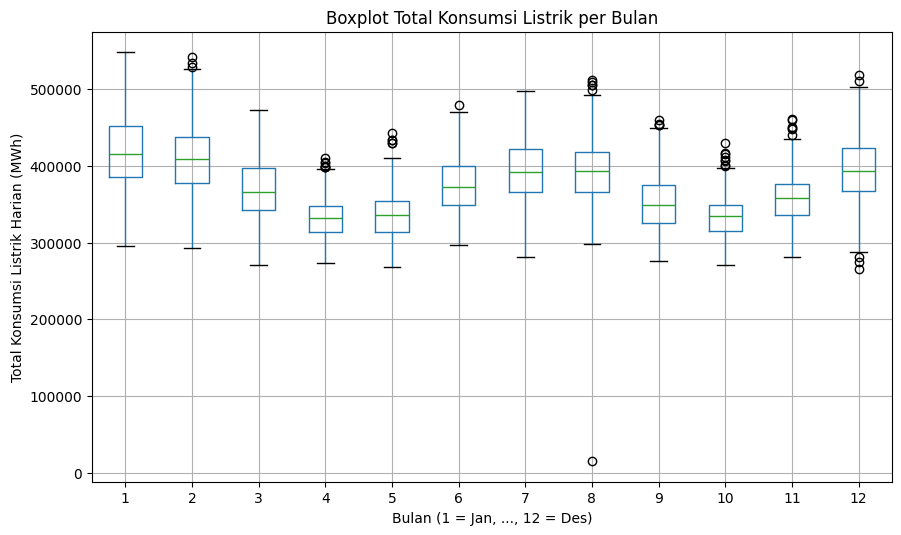

In [16]:
daily_df['month'] = daily_df.index.month

# Buat boxplot untuk lihat distribusi konsumsi per bulan
daily_df.boxplot(column='AEP_MW', by='month', figsize=(10, 6))
plt.title("Boxplot Total Konsumsi Listrik per Bulan")
plt.suptitle('')
plt.xlabel("Bulan (1 = Jan, ..., 12 = Des)")
plt.ylabel("Total Konsumsi Listrik Harian (MWh)")
plt.grid(True)
plt.show()

In [17]:
# Drop missing value dari train dan test
train = daily_df[daily_df.index < '2014-01-01'].dropna()
test = daily_df[daily_df.index >= '2014-01-01'].dropna()

In [18]:
print("Max:", daily_df['AEP_MW'].max())
print("Min:", daily_df['AEP_MW'].min())
print("Mean:", daily_df['AEP_MW'].mean())

Max: 548349.0
Min: 14809.0
Mean: 371844.21899109794


In [ ]:
# AutoTS model setup
model = AutoTS(
    forecast_length=len(test),
    frequency='D',
    ensemble='simple',
    model_list='fast',  # bisa juga 'superfast', 'default', dll
    max_generations=5,
    num_validations=2
)

# Fit model (ini harus DataFrame dengan kolom 1, bernama seri)
model = model.fit(train[['AEP_MW']])

# Predict
prediction = model.predict()
forecast = prediction.forecast['AEP_MW']

# Hitung RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_autots = np.sqrt(mean_squared_error(test['AEP_MW'], forecast))
print("AutoTS RMSE:", rmse_autots)

Using 8 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Too many training validations for length of data provided, decreasing num_validations to 0
Model Number: 1 with model AverageValueNaive in generation 0 of 5
Model Number: 2 with model AverageValueNaive in generation 0 of 5
Model Number: 3 with model AverageValueNaive in generation 0 of 5
Model Number: 4 with model DatepartRegression in generation 0 of 5
Model Number: 5 with model DatepartRegression in generation 0 of 5
Model Number: 6 with model DatepartRegression in generation 0 of 5
Model Number: 7 with model DatepartRegression in generation 0 of 5
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7 in generation 0: DatepartRegression
Model Number: 8 with model ETS in generation 0 of 5
Model Number: 9 with model ETS in generation 0 of 5
Model Number: 10 with model GLM in generation 0 of 5
Model Number: 11 with model GLM in generation 0 of 5
Model Number: 12 wi

In [ ]:
print(model.best_model)
print(model.results().head())

                                   ID      Model  \
275  75c33c56938665355c6f9aec757b8573  Cassandra   

                                       ModelParameters  \
275  {"preprocessing_transformation": {"fillna": "c...   

                              TransformationParameters  Ensemble  
275  {"fillna": "piecewise_polynomial", "transforma...         0  
                                   ID             Model  \
699  75c33c56938665355c6f9aec757b8573         Cassandra   
679  6d251733f7beadec7d44a10c1ee5e5de  BasicLinearModel   
546  73d05fb452ddd6cd6d7caf689cd6b085         Cassandra   
551  0861c4fe52539a5adc754dcff83ced94         Cassandra   
684  cf3c4df558f9b95aa099581d6030a043  BasicLinearModel   

                                       ModelParameters  \
699  {"preprocessing_transformation": {"fillna": "c...   
679  {"datepart_method": "common_fourier", "changep...   
546  {"preprocessing_transformation": {"fillna": "f...   
551  {"preprocessing_transformation": {"fillna": "f...   

In [ ]:
# SETUP Cassandra super ringan
model = AutoTS(
    forecast_length=len(test),
    frequency='D',
    ensemble='none',
    model_list=["Cassandra"],   # hanya model Cassandra
    max_generations=1,          # hanya 1 generasi
    num_validations=1           # validasi sekali aja
)

# Fit dan prediksi
model = model.fit(train[['AEP_MW']])
prediction = model.predict()
forecast = prediction.forecast['AEP_MW']

# Hitung RMSE
rmse_cassandra = np.sqrt(mean_squared_error(test['AEP_MW'], forecast))
print("RMSE Cassandra (Lite):", rmse_cassandra)

Using 8 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Too many training validations for length of data provided, decreasing num_validations to 0
Model Number: 1 with model Cassandra in generation 0 of 1
Model Number: 2 with model Cassandra in generation 0 of 1
Model Number: 3 with model Cassandra in generation 0 of 1


c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\tools\seasonal.py:924: RuntimeWarning: invalid value encountered in divide
  scores = np.mean(np.abs(a - b) / divisor, axis=2)
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\tools\seasonal.py:924: RuntimeWarning: invalid value encountered in divide
  scores = np.mean(np.abs(a - b) / divisor, axis=2)
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\tools\seasonal.py:924: RuntimeWarning: invalid value encountered in divide
  scores = np.mean(np.abs(a - b) / divisor, axis=2)


Model Number: 4 with model Cassandra in generation 0 of 1
Model Number: 5 with model Cassandra in generation 0 of 1
Template Eval Error: LinAlgError('Singular matrix') in model 5 in generation 0: Cassandra
Model Number: 6 with model Cassandra in generation 0 of 1
Model Number: 7 with model Cassandra in generation 0 of 1


c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0.0)
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\tools\anomaly_utils.py:1266: FutureWarning: Downcasting object dtype arrays on .filln

Model Number: 8 with model Cassandra in generation 0 of 1
Model Number: 9 with model Cassandra in generation 0 of 1
Template Eval Error: Exception("Transformer Detrend failed on fit from params cubic {'0': {'method': 'clip', 'std_threshold': 3, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': 365, 'transform_dict': {'fillna': None, 'transformations': {'0': 'AnomalyRemoval'}, 'transformation_params': {'0': {'method': 'zscore', 'transform_dict': {'transformations': {'0': 'DatepartRegression'}, 'transformation_params': {'0': {'datepart_method': 'simple_3', 'regression_model': {'model': 'ElasticNet', 'model_params': {}}}}}, 'method_params': {'distribution': 'uniform', 'alpha': 0.05}}}}}} with error ValueError('Input y contains NaN.')") in model 9 in generation 0: Cassandra
New Generation: 1 of 1
Model Number: 10 with model Cassandra in generation 1 of 1
Model Number: 11 with model Cassandra in generation 1 of 1
Template Eval Error: Exception("Transformer Cointegration failed o

c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 13 with model Cassandra in generation 1 of 1


c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.29353e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 14 with model Cassandra in generation 1 of 1


c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\71485\Documents\introphyton\myvenv\Lib\site-packages\autots\evaluator\auto_model.py:3068: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(


RMSE Cassandra (Lite): 35625.83649314225


In [ ]:
# Hitung RMSE Cassandra
rmse_cassandra = np.sqrt(mean_squared_error(test['AEP_MW'], forecast))

# Hitung rata-rata aktual
mean_actual = test['AEP_MW'].mean()

# Hitung persentase RMSE
rmse_percent = (rmse_cassandra / mean_actual) * 100
print(f"RMSE Cassandra (% of mean): {rmse_percent:.2f}%")


RMSE Cassandra (% of mean): 9.98%


In [42]:
# Ambil data Prophet
df_full_prophet = daily_df[['AEP_MW']].reset_index()
df_full_prophet.columns = ['ds', 'y']

# Split: sebelum dan sesudah 2014
df_train_prophet = df_full_prophet[df_full_prophet['ds'] < '2014-01-01']
df_test_prophet = df_full_prophet[df_full_prophet['ds'] >= '2014-01-01']

# Fit model Prophet
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_prophet.fit(df_train_prophet)

# Forecast sebanyak panjang test
future = model_prophet.make_future_dataframe(periods=len(df_test_prophet), freq='D')
forecast = model_prophet.predict(future)

# Ambil prediksi untuk periode test
yhat_prophet = forecast.set_index('ds').loc[df_test_prophet['ds'], 'yhat']

# Hitung RMSE dan persentase
rmse_prophet = np.sqrt(mean_squared_error(df_test_prophet['y'], yhat_prophet))
mean_actual = df_test_prophet['y'].mean()
rmse_prophet_pct = (rmse_prophet / mean_actual) * 100

# Tampilkan hasil
print(f"Prophet RMSE: {rmse_prophet:.2f} ({rmse_prophet_pct:.2f}%)")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuoyeuaa2/fw8jz27o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuoyeuaa2/8r5z3n45.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52455', 'data', 'file=/tmp/tmpuoyeuaa2/fw8jz27o.json', 'init=/tmp/tmpuoyeuaa2/8r5z3n45.json', 'output', 'file=/tmp/tmpuoyeuaa2/prophet_model3yfimibc/prophet_model-20250619150402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:04:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 35745.65 (10.01%)


In [43]:
# Data sebelum 2014 = training, sesudah 2014 = testing
train_hw = daily_df[daily_df.index < '2014-01-01']['AEP_MW']
test_hw = daily_df[daily_df.index >= '2014-01-01']['AEP_MW']

# Fit model
hw_model = ExponentialSmoothing(train_hw, trend='add', seasonal='add', seasonal_periods=365)
hw_fit = hw_model.fit()

# Forecast
forecast_hw = hw_fit.forecast(len(test_hw))

# Evaluasi
rmse_hw = np.sqrt(mean_squared_error(test_hw, forecast_hw))
rmse_hw_pct = (rmse_hw / test_hw.mean()) * 100

print(f"Holt-Winters RMSE: {rmse_hw:.2f} ({rmse_hw_pct:.2f}%)")

Holt-Winters RMSE: 76681.83 (21.48%)


In [44]:
# Preprocess
series = daily_df['AEP_MW'].values.reshape(-1, 1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

def create_seq(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_seq(series_scaled, seq_length)

# Bagi train/test berdasarkan tanggal
split_index = daily_df.index.get_loc('2014-01-01') - seq_length
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict & inverse scale
pred_lstm = model_lstm.predict(X_test)
rmse_lstm = np.sqrt(mean_squared_error(
    scaler.inverse_transform(y_test),
    scaler.inverse_transform(pred_lstm)
))
rmse_lstm_pct = (rmse_lstm / scaler.inverse_transform(y_test).mean()) * 100

print(f"LSTM RMSE: {rmse_lstm:.2f} ({rmse_lstm_pct:.2f}%)")

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.1974
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0040
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0039
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0038
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0037
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0041
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0039
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0038
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0038
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0036
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0035
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0035
Epoch 13/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0035
Epoch 14/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0035
Epoch 15/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s

In [45]:
# GRU model
model_gru = Sequential()
model_gru.add(GRU(64, activation='relu', input_shape=(seq_length, 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer=Adam(0.001), loss='mse')
model_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict & inverse scale
pred_gru = model_gru.predict(X_test)
rmse_gru = np.sqrt(mean_squared_error(
    scaler.inverse_transform(y_test),
    scaler.inverse_transform(pred_gru)
))
rmse_gru_pct = (rmse_gru / scaler.inverse_transform(y_test).mean()) * 100

print(f"GRU RMSE: {rmse_gru:.2f} ({rmse_gru_pct:.2f}%)")

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1490
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0033
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0032
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0031
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0029
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0030
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0028
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0028
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0028
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0027
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0025
Epoch 13/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0025
Epoch 14/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0025
Epoch 15/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s

In [24]:
# === RANDOM FOREST MODEL ===
def create_lag_features(df, lag=7):
    df_lag = df.copy()
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = df_lag['AEP_MW'].shift(i)
    return df_lag.dropna()

rf_df = create_lag_features(daily_df, lag=7)
train_rf = rf_df[rf_df.index < '2014-01-01']
test_rf = rf_df[rf_df.index >= '2014-01-01']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_rf.drop('AEP_MW', axis=1), train_rf['AEP_MW'])
pred_rf = rf_model.predict(test_rf.drop('AEP_MW', axis=1))
rmse_rf = np.sqrt(mean_squared_error(test_rf['AEP_MW'], pred_rf))
rmse_rf_percent = (rmse_rf / test_rf['AEP_MW'].mean()) * 100
print(f"Random Forest RMSE: {rmse_rf:.2f} ({rmse_rf_percent:.2f}%)")

Random Forest RMSE: 24336.72 (6.82%)


In [25]:
from sklearn.neural_network import MLPRegressor

# Lag features (sama kayak RF)
def create_lag_features(df, lag=7):
    df_lag = df.copy()
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = df_lag['AEP_MW'].shift(i)
    return df_lag.dropna()

nn_df = create_lag_features(daily_df, lag=7)
train_nn = nn_df[nn_df.index < '2014-01-01']
test_nn = nn_df[nn_df.index >= '2014-01-01']

# Train model
nn = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
nn.fit(train_nn.drop('AEP_MW', axis=1), train_nn['AEP_MW'])

# Predict
pred_nn = nn.predict(test_nn.drop('AEP_MW', axis=1))

# Evaluate
rmse_nn = np.sqrt(mean_squared_error(test_nn['AEP_MW'], pred_nn))
mean_actual = test['AEP_MW'].mean()
rmse_nn_percent = (rmse_nn / mean_actual) * 100

print(f"Neural Net RMSE: {rmse_nn:.2f} ({rmse_nn_percent:.2f}%)")


Neural Net RMSE: 23602.44 (6.61%)


In [27]:
# Samakan panjang semua prediksi
min_len = min(len(pred_rf), len(pred_nn), len(pred_gru_inv), len(pred_lstm))
rf_pred = pred_rf[:min_len]
nn_pred = pred_nn[:min_len]
gru_pred = pred_gru_inv.flatten()[:min_len]
lstm_pred = pred_lstm.flatten()[:min_len]
actual = test['AEP_MW'].values[:min_len]

# === Ensemble RF + NN + GRU ===
ensemble_3 = 0.5 * nn_pred + 0.3 * rf_pred + 0.2 * gru_pred
rmse_3 = np.sqrt(mean_squared_error(actual, ensemble_3))
rmse_3_pct = (rmse_3 / mean_actual) * 100
print(f"RF + NN + GRU RMSE: {rmse_3:.2f} ({rmse_3_pct:.2f}%)")

# === Ensemble RF + NN + GRU + LSTM ===
ensemble_4 = 0.4 * nn_pred + 0.3 * rf_pred + 0.15 * gru_pred + 0.15 * lstm_pred
rmse_4 = np.sqrt(mean_squared_error(actual, ensemble_4))
rmse_4_pct = (rmse_4 / mean_actual) * 100
print(f"RF + NN + GRU + LSTM RMSE: {rmse_4:.2f} ({rmse_4_pct:.2f}%)")


RF + NN + GRU RMSE: 24561.79 (6.88%)
RF + NN + GRU + LSTM RMSE: 60299.05 (16.89%)


In [31]:

# === Feature Engineering ===
daily_df['month'] = daily_df.index.month
daily_df['week_of_year'] = daily_df.index.isocalendar().week
daily_df['day_of_week'] = daily_df.index.dayofweek

def create_lag_features(df, lag=7):
    df_lag = df.copy()
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = df_lag['AEP_MW'].shift(i)
    return df_lag.dropna()

df_lagged = create_lag_features(daily_df)

# === Split Train & Test ===
train = df_lagged[df_lagged.index < '2014-01-01']
test = df_lagged[df_lagged.index >= '2014-01-01']

X_train = train.drop('AEP_MW', axis=1)
y_train = train['AEP_MW']
X_test = test.drop('AEP_MW', axis=1)
y_test = test['AEP_MW']

# === Random Forest ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)

# === MLP Neural Network ===
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)
pred_nn = nn_model.predict(X_test)

# === Ensemble Weighted (60% NN, 40% RF) ===
ensemble_pred = 0.6 * pred_nn + 0.4 * pred_rf

# === RMSE Evaluation ===
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
rmse_nn = np.sqrt(mean_squared_error(y_test, pred_nn))

rmse_pct = (rmse_ensemble / y_test.mean()) * 100

print(f"Random Forest RMSE   : {rmse_rf:.2f}")
print(f"MLP Neural Net RMSE  : {rmse_nn:.2f}")
print(f"Updated Ensemble RMSE: {rmse_ensemble:.2f} ({rmse_pct:.2f}%)")

# === Simpan hasil ke DataFrame untuk analisis/plot ===
ensemble_df = pd.DataFrame({
    'Actual': y_test.values,
    'RF_Predicted': pred_rf,
    'NN_Predicted': pred_nn,
    'Ensemble_Predicted': ensemble_pred
}, index=y_test.index)

ensemble_df['Month'] = ensemble_df.index.month
ensemble_df['Week'] = ensemble_df.index.isocalendar().week
ensemble_df['Day'] = ensemble_df.index.day_name()

Random Forest RMSE   : 21041.11
MLP Neural Net RMSE  : 24056.83
Updated Ensemble RMSE: 21556.88 (6.04%)


In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train_nn = train_nn.drop('AEP_MW', axis=1)
y_train_nn = train_nn['AEP_MW']

X_test_nn = test_nn.drop('AEP_MW', axis=1)
y_test_nn = test_nn['AEP_MW']

# === Membangun Model ===
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_dim=X_train_nn.shape[1]))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # output layer

# === Kompilasi Model ===
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# === Training Model ===
history = nn_model.fit(
    X_train_nn,
    y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 17101620224.0000 - val_loss: 833430912.0000
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 829478976.0000 - val_loss: 760096704.0000
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 725904512.0000 - val_loss: 796687232.0000
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 761294272.0000 - val_loss: 730491520.0000
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 714621248.0000 - val_loss: 668877504.0000
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 713065664.0000 - val_loss: 655294144.0000
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 632609664.0000 - val_loss: 636554880.0000
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 667365952.0000 - val_loss: 624672640.0000
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 679103872.0000 - val_loss: 607509248.0000
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 600265344.0000 - val_loss: 5

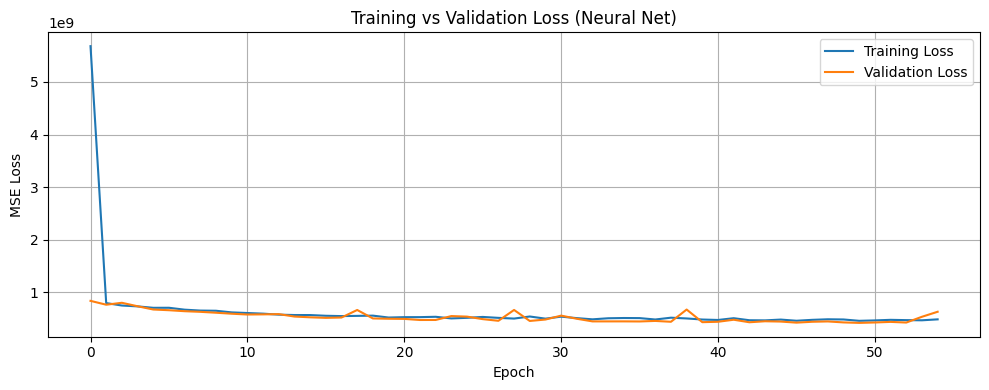

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Neural Net)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


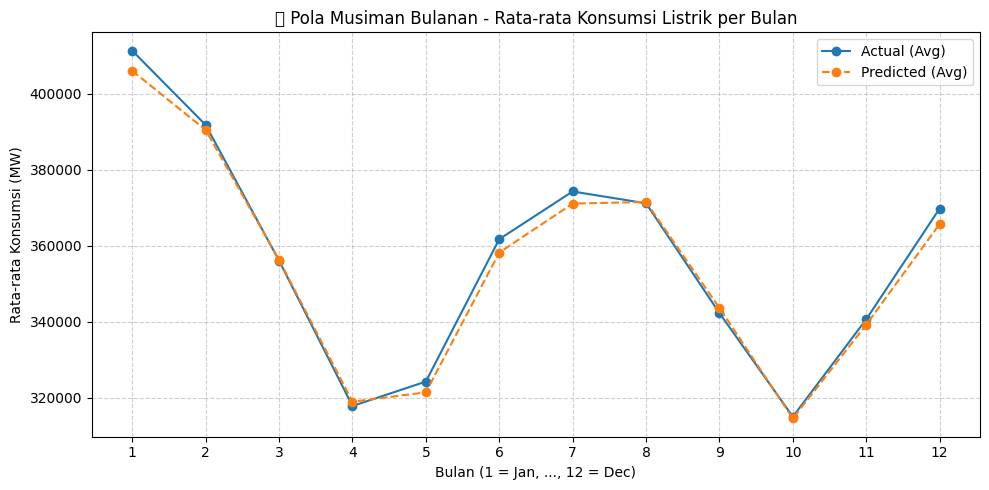

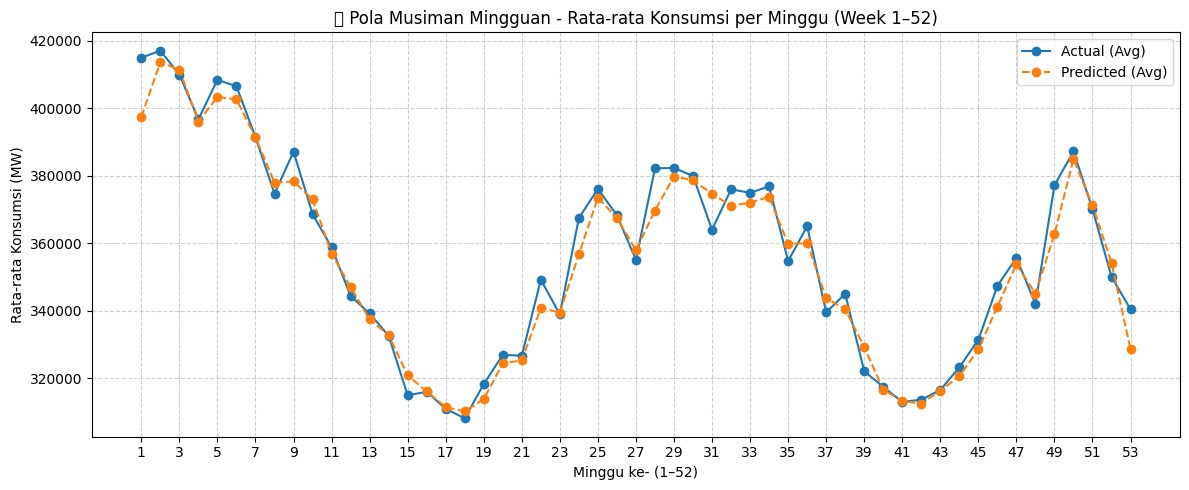

In [33]:
# === Pola Bulanan ===
monthly_avg = ensemble_df.groupby('Month')[['Actual', 'Ensemble_Predicted']].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg['Actual'], label='Actual (Avg)', marker='o')
plt.plot(monthly_avg.index, monthly_avg['Ensemble_Predicted'], label='Predicted (Avg)', marker='o', linestyle='--')
plt.title('📈 Pola Musiman Bulanan - Rata-rata Konsumsi Listrik per Bulan')
plt.xlabel('Bulan (1 = Jan, ..., 12 = Dec)')
plt.ylabel('Rata-rata Konsumsi (MW)')
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# === Pola Mingguan ===
weekly_avg = ensemble_df.groupby('Week')[['Actual', 'Ensemble_Predicted']].mean()

plt.figure(figsize=(12, 5))
plt.plot(weekly_avg.index, weekly_avg['Actual'], label='Actual (Avg)', marker='o')
plt.plot(weekly_avg.index, weekly_avg['Ensemble_Predicted'], label='Predicted (Avg)', marker='o', linestyle='--')
plt.title('📅 Pola Musiman Mingguan - Rata-rata Konsumsi per Minggu (Week 1–52)')
plt.xlabel('Minggu ke- (1–52)')
plt.ylabel('Rata-rata Konsumsi (MW)')
plt.xticks(ticks=range(1, 54, 2))  # biar tidak terlalu padat
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()